# Homework 1

## Instructions
Recording 11:32

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL25Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/homework-1.ipynb) of this homework from your local copy.

For part A, fill in the code and answers within the notebook and save your changes.

For part B, create and archive the necessary Python/shell scripts together.

Finally, upload the notebook and the archive to the assignment in ILIAS.

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [2]:
import pandas as pd
import seaborn as sns
from tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

#### Answer

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tutorial_1a.hfl_complete import Subset, GradientClient, DecentralizedServer, RunResult, split
from torch.optim import SGD
from time import perf_counter
from tqdm import tqdm
import torch

data_path = "./data"
ETA = "\N{GREEK SMALL LETTER ETA}"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.backends.cudnn.deterministic = True

transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize by training set mean and standard deviation
    # resulting data has mean=0 and std=1
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    # decrease batch size if running into memory issues when testing
    # a bespoke generator is passed to avoid reproducibility issues
    shuffle=False, drop_last=False, batch_size=10000, generator=torch.Generator())

In [5]:
class FedSgdWeightServer(DecentralizedServer):
    def __init__(
            self, lr: float,
            client_subsets: list[Subset], client_fraction: float, seed: int) -> None:
        super().__init__(lr, -1, client_subsets, client_fraction, seed)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.clients = [GradientClient(subset) for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            "FedSGDWeight", self.nr_clients, self.client_fraction, -1, 1, self.lr, self.seed)

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            self.optimizer.zero_grad()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weights, server_parameter in zip_weight_parameter:
                    server_parameter.grad = client_weights.to(device=device)

            self.optimizer.step()
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [14]:
sample_split_1 = split(100, True, seed=10)

fedsgd_weight_server1 = FedSgdWeightServer(0.01, sample_split_1, 0.5, seed=10)
result_fedsgd_weight1 = fedsgd_weight_server1.run(5)
fedsgd_weight_df1 = result_fedsgd_weight1.as_df()
fedsgd_weight_df1

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDWeight,100,0.5,∞,1,0.01,10,100,8.91
1,2,FedSGDWeight,100,0.5,∞,1,0.01,10,200,13.42
2,3,FedSGDWeight,100,0.5,∞,1,0.01,10,300,18.44
3,4,FedSGDWeight,100,0.5,∞,1,0.01,10,400,23.01
4,5,FedSGDWeight,100,0.5,∞,1,0.01,10,500,27.58


In [15]:
fedsgd_gradient_server1 = FedSgdGradientServer(0.01, sample_split_1, 0.5, seed=10)
result_fedsgd_gradient1 = fedsgd_gradient_server1.run(5)
fedsgd_gradient_df1 = result_fedsgd_gradient1.as_df()
fedsgd_gradient_df1

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.5,∞,1,0.01,10,100,8.91
1,2,FedSGDGradient,100,0.5,∞,1,0.01,10,200,13.42
2,3,FedSGDGradient,100,0.5,∞,1,0.01,10,300,18.44
3,4,FedSGDGradient,100,0.5,∞,1,0.01,10,400,23.01
4,5,FedSGDGradient,100,0.5,∞,1,0.01,10,500,27.58


In [16]:
sample_split_2 = split(50, False, seed=10)

fedsgd_weight_server2 = FedSgdWeightServer(0.1, sample_split_2, 0.2, seed=10)
result_fedsgd_weight2 = fedsgd_weight_server2.run(5)
fedsgd_weight_df2 = result_fedsgd_weight2.as_df()
fedsgd_weight_df2

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDWeight,50,0.2,∞,1,0.1,10,20,15.51
1,2,FedSGDWeight,50,0.2,∞,1,0.1,10,40,24.64
2,3,FedSGDWeight,50,0.2,∞,1,0.1,10,60,13.57
3,4,FedSGDWeight,50,0.2,∞,1,0.1,10,80,20.00
4,5,FedSGDWeight,50,0.2,∞,1,0.1,10,100,40.26


In [17]:
fedsgd_gradient_server2 = FedSgdGradientServer(0.1, sample_split_2, 0.2, seed=10)
result_fedsgd_gradient2 = fedsgd_gradient_server2.run(5)
fedsgd_gradient_df2 = result_fedsgd_gradient2.as_df()
fedsgd_gradient_df2

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,50,0.2,∞,1,0.1,10,20,15.51
1,2,FedSGDGradient,50,0.2,∞,1,0.1,10,40,24.64
2,3,FedSGDGradient,50,0.2,∞,1,0.1,10,60,13.57
3,4,FedSGDGradient,50,0.2,∞,1,0.1,10,80,20.00
4,5,FedSGDGradient,50,0.2,∞,1,0.1,10,100,40.26


In [18]:
fedsgd_weight_df1["Test accuracy"] - fedsgd_gradient_df1["Test accuracy"]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Test accuracy, dtype: float64

In [19]:
fedsgd_weight_df2["Test accuracy"] - fedsgd_gradient_df2["Test accuracy"]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Test accuracy, dtype: float64

### Comparison
We can see that the difference in test accuracy between FedSGD with weights and gradients is 0.0. Indicating no difference at all.
### When the same?
FedAvg and FedSGD with weights are equivalent when the learning rate, client subsets, and client fraction are the same. Additionaly the number of local epochs in FedAvg should be 1, as simulated by changing the standard FedSGD instead of the FedAvg.

### Exercise A2: Client number & fraction (4 points)

#### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- |---------------|---------------|
| FedSGD    | 10  | 0.1 | 20            | 43.23         |
| FedAvg    | 10  | 0.1 | 20            | 93.22         |
| FedSGD    | 50  | 0.1 | 100           | 43.11         |
| FedAvg    | 50  | 0.1 | 100           | 87.93         |
| FedSGD    | 100 | 0.1 | 200           | 43.17         |
| FedAvg    | 100 | 0.1 | 200           | 81.33         |

Is the relationship between the metrics and client numbers monotonous?

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- |---------------|---------------|
| FedSGD    | 100 | 0.01 | 20            | 41.90         |
| FedAvg    | 100 | 0.01 | 20            | 73.41         |
| FedSGD    | 100 | 0.1  | 200           | 43.17         |
| FedAvg    | 100 | 0.1  | 200           | 81.33         |
| FedSGD    | 100 | 0.2  | 400           | 42.88         |
| FedAvg    | 100 | 0.2  | 400           | 81.92         |

How does the observed pattern differ?

#### Answer

In [8]:
# TODO
from IPython.display import display
# n = 100
# lr = 0.01
# c = 0.1
# e = 1
# b = 100
# nr_rounds = 10
# iid = True
# seed = 10
from tutorial_1a.hfl_complete import FedAvgServer
N = [10, 50, 100]
C = [0.1]
Algorithm = ["FedSGD", "FedAvg"]
for n in N:
    for c in C:
        sample_split = split(n, iid, seed=10)
        for alg in Algorithm:
            if alg == "FedSGD":
                server = FedSgdGradientServer(lr, sample_split, c, seed=seed)
            else:
                server = FedAvgServer(lr, b, sample_split, c, e ,seed=seed)
            result = server.run(nr_rounds)
            df = result.as_df()
            display(df)

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,10,0.1,∞,1,0.01,10,2,9.28
1,2,FedSGDGradient,10,0.1,∞,1,0.01,10,4,14.01
2,3,FedSGDGradient,10,0.1,∞,1,0.01,10,6,18.99
3,4,FedSGDGradient,10,0.1,∞,1,0.01,10,8,23.00
4,5,FedSGDGradient,10,0.1,∞,1,0.01,10,10,27.40
5,6,FedSGDGradient,10,0.1,∞,1,0.01,10,12,31.12
6,7,FedSGDGradient,10,0.1,∞,1,0.01,10,14,35.87
7,8,FedSGDGradient,10,0.1,∞,1,0.01,10,16,39.08
8,9,FedSGDGradient,10,0.1,∞,1,0.01,10,18,41.88
9,10,FedSGDGradient,10,0.1,∞,1,0.01,10,20,43.23


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,10,0.1,100,1,0.01,10,2,74.82
1,2,FedAvg,10,0.1,100,1,0.01,10,4,86.51
2,3,FedAvg,10,0.1,100,1,0.01,10,6,88.87
3,4,FedAvg,10,0.1,100,1,0.01,10,8,90.66
4,5,FedAvg,10,0.1,100,1,0.01,10,10,91.25
5,6,FedAvg,10,0.1,100,1,0.01,10,12,91.77
6,7,FedAvg,10,0.1,100,1,0.01,10,14,92.28
7,8,FedAvg,10,0.1,100,1,0.01,10,16,92.88
8,9,FedAvg,10,0.1,100,1,0.01,10,18,92.07
9,10,FedAvg,10,0.1,100,1,0.01,10,20,93.22


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,50,0.1,∞,1,0.01,10,10,9.44
1,2,FedSGDGradient,50,0.1,∞,1,0.01,10,20,13.93
2,3,FedSGDGradient,50,0.1,∞,1,0.01,10,30,18.58
3,4,FedSGDGradient,50,0.1,∞,1,0.01,10,40,23.04
4,5,FedSGDGradient,50,0.1,∞,1,0.01,10,50,27.46
5,6,FedSGDGradient,50,0.1,∞,1,0.01,10,60,31.30
6,7,FedSGDGradient,50,0.1,∞,1,0.01,10,70,35.45
7,8,FedSGDGradient,50,0.1,∞,1,0.01,10,80,38.59
8,9,FedSGDGradient,50,0.1,∞,1,0.01,10,90,41.49
9,10,FedSGDGradient,50,0.1,∞,1,0.01,10,100,43.11


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,50,0.1,100,1,0.01,10,10,46.83
1,2,FedAvg,50,0.1,100,1,0.01,10,20,65.78
2,3,FedAvg,50,0.1,100,1,0.01,10,30,66.52
3,4,FedAvg,50,0.1,100,1,0.01,10,40,77.62
4,5,FedAvg,50,0.1,100,1,0.01,10,50,81.42
5,6,FedAvg,50,0.1,100,1,0.01,10,60,83.54
6,7,FedAvg,50,0.1,100,1,0.01,10,70,85.72
7,8,FedAvg,50,0.1,100,1,0.01,10,80,86.34
8,9,FedAvg,50,0.1,100,1,0.01,10,90,87.20
9,10,FedAvg,50,0.1,100,1,0.01,10,100,87.93


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,20,8.77
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,40,13.57
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,60,18.44
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,80,23.18
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,100,27.38
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,120,31.35
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,140,35.85
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,160,39.06
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,180,41.25
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,200,43.17


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,20,30.82
1,2,FedAvg,100,0.1,100,1,0.01,10,40,46.46
2,3,FedAvg,100,0.1,100,1,0.01,10,60,55.64
3,4,FedAvg,100,0.1,100,1,0.01,10,80,62.25
4,5,FedAvg,100,0.1,100,1,0.01,10,100,69.80
5,6,FedAvg,100,0.1,100,1,0.01,10,120,72.91
6,7,FedAvg,100,0.1,100,1,0.01,10,140,74.89
7,8,FedAvg,100,0.1,100,1,0.01,10,160,77.11
8,9,FedAvg,100,0.1,100,1,0.01,10,180,77.92
9,10,FedAvg,100,0.1,100,1,0.01,10,200,81.33


### Is the relationship between the metrics and client numbers monotonous?
The message count increases with the number of clients for both algorithms (Quite intuitively).<br>The relationship for the test accuracy is monotonous for FedAvg, as the accuracy decreases with the number of clients.<br> The relationship for FedSGD is not monotonous, as the test accuracy is not consistently decreasing with the number of clients. There is a slight increase in accuracy when the number of clients go from 50 to 100.

In [9]:
# TODO
N = [100]
C = [0.01,0.1,0.2]
Algorithm = ["FedSGD", "FedAvg"]
for n in N:
    for c in C:
        sample_split = split(n, iid, seed=10)
        for alg in Algorithm:
            if alg == "FedSGD":
                server = FedSgdGradientServer(lr, sample_split, c, seed=seed)
            else:
                server = FedAvgServer(lr, b, sample_split, c, e ,seed=seed)
            result = server.run(nr_rounds)
            df = result.as_df()
            display(df)

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.01,∞,1,0.01,10,2,9.93
1,2,FedSGDGradient,100,0.01,∞,1,0.01,10,4,14.73
2,3,FedSGDGradient,100,0.01,∞,1,0.01,10,6,20.31
3,4,FedSGDGradient,100,0.01,∞,1,0.01,10,8,24.43
4,5,FedSGDGradient,100,0.01,∞,1,0.01,10,10,27.92
5,6,FedSGDGradient,100,0.01,∞,1,0.01,10,12,32.34
6,7,FedSGDGradient,100,0.01,∞,1,0.01,10,14,36.81
7,8,FedSGDGradient,100,0.01,∞,1,0.01,10,16,39.49
8,9,FedSGDGradient,100,0.01,∞,1,0.01,10,18,41.79
9,10,FedSGDGradient,100,0.01,∞,1,0.01,10,20,41.90


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.01,100,1,0.01,10,2,30.59
1,2,FedAvg,100,0.01,100,1,0.01,10,4,45.48
2,3,FedAvg,100,0.01,100,1,0.01,10,6,44.84
3,4,FedAvg,100,0.01,100,1,0.01,10,8,58.70
4,5,FedAvg,100,0.01,100,1,0.01,10,10,64.96
5,6,FedAvg,100,0.01,100,1,0.01,10,12,67.14
6,7,FedAvg,100,0.01,100,1,0.01,10,14,62.05
7,8,FedAvg,100,0.01,100,1,0.01,10,16,72.58
8,9,FedAvg,100,0.01,100,1,0.01,10,18,70.95
9,10,FedAvg,100,0.01,100,1,0.01,10,20,73.41


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.1,∞,1,0.01,10,20,8.77
1,2,FedSGDGradient,100,0.1,∞,1,0.01,10,40,13.57
2,3,FedSGDGradient,100,0.1,∞,1,0.01,10,60,18.44
3,4,FedSGDGradient,100,0.1,∞,1,0.01,10,80,23.18
4,5,FedSGDGradient,100,0.1,∞,1,0.01,10,100,27.38
5,6,FedSGDGradient,100,0.1,∞,1,0.01,10,120,31.35
6,7,FedSGDGradient,100,0.1,∞,1,0.01,10,140,35.85
7,8,FedSGDGradient,100,0.1,∞,1,0.01,10,160,39.06
8,9,FedSGDGradient,100,0.1,∞,1,0.01,10,180,41.25
9,10,FedSGDGradient,100,0.1,∞,1,0.01,10,200,43.17


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.1,100,1,0.01,10,20,30.82
1,2,FedAvg,100,0.1,100,1,0.01,10,40,46.46
2,3,FedAvg,100,0.1,100,1,0.01,10,60,55.64
3,4,FedAvg,100,0.1,100,1,0.01,10,80,62.25
4,5,FedAvg,100,0.1,100,1,0.01,10,100,69.80
5,6,FedAvg,100,0.1,100,1,0.01,10,120,72.91
6,7,FedAvg,100,0.1,100,1,0.01,10,140,74.89
7,8,FedAvg,100,0.1,100,1,0.01,10,160,77.11
8,9,FedAvg,100,0.1,100,1,0.01,10,180,77.92
9,10,FedAvg,100,0.1,100,1,0.01,10,200,81.33


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGDGradient,100,0.2,∞,1,0.01,10,40,8.90
1,2,FedSGDGradient,100,0.2,∞,1,0.01,10,80,13.77
2,3,FedSGDGradient,100,0.2,∞,1,0.01,10,120,18.33
3,4,FedSGDGradient,100,0.2,∞,1,0.01,10,160,23.13
4,5,FedSGDGradient,100,0.2,∞,1,0.01,10,200,27.42
5,6,FedSGDGradient,100,0.2,∞,1,0.01,10,240,31.96
6,7,FedSGDGradient,100,0.2,∞,1,0.01,10,280,35.64
7,8,FedSGDGradient,100,0.2,∞,1,0.01,10,320,39.07
8,9,FedSGDGradient,100,0.2,∞,1,0.01,10,360,40.97
9,10,FedSGDGradient,100,0.2,∞,1,0.01,10,400,42.88


,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,100,1,0.01,10,40,31.12
1,2,FedAvg,100,0.2,100,1,0.01,10,80,45.02
2,3,FedAvg,100,0.2,100,1,0.01,10,120,55.71
3,4,FedAvg,100,0.2,100,1,0.01,10,160,60.68
4,5,FedAvg,100,0.2,100,1,0.01,10,200,65.15
5,6,FedAvg,100,0.2,100,1,0.01,10,240,71.38
6,7,FedAvg,100,0.2,100,1,0.01,10,280,73.30
7,8,FedAvg,100,0.2,100,1,0.01,10,320,74.51
8,9,FedAvg,100,0.2,100,1,0.01,10,360,80.39
9,10,FedAvg,100,0.2,100,1,0.01,10,400,81.92


### How does the observed pattern differ?
The test accuracy monotously increases for the FedAvg with the fraction of clients, while the test accuracy is not monotonous for FedSGD, as the highest test accuracy is achieved with a client fraction of 0.1, not 0.2. The message count increases with the same scaler as the fraction of clients for both algorithms. 

### Exercise A3: Local epoch count & (non-)IID data (5 points)

#### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

#### Answer

<Axes: xlabel='Round', ylabel='Test accuracy'>

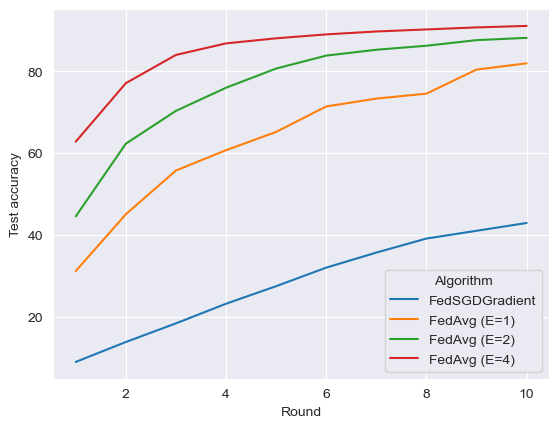

In [12]:
# n = 100
# lr = 0.01
# c = 0.1
# e = 1
# b = 100
# nr_rounds = 10
# iid = True
# seed = 10

epoch = [1, 2, 4]
sample_split = split(n, iid, seed=10)

server = FedSgdGradientServer(lr, sample_split, c, seed=seed)
result = server.run(nr_rounds)
df_SDG = result.as_df()
dfs = [df_SDG]
for epochs in epoch:
    server = FedAvgServer(lr, b, sample_split, c, epochs ,seed=seed)
    result = server.run(nr_rounds)
    df_temp = result.as_df()
    df_temp["Algorithm"] = f"FedAvg (E={epochs})"
    dfs.append(df_temp)
df = pd.concat(dfs)
sns.lineplot(data=df, x="Round", y="Test accuracy", hue="Algorithm")

### How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?
FedAvg has a higher test accuracy than FedSGD. The effect of increasing the work clients perform locally for each update in FedAvg is that the test accuracy increases with the number of local epochs. The test accuracy is highest for FedAvg with 4 local epochs.

<Axes: xlabel='Round', ylabel='Test accuracy'>

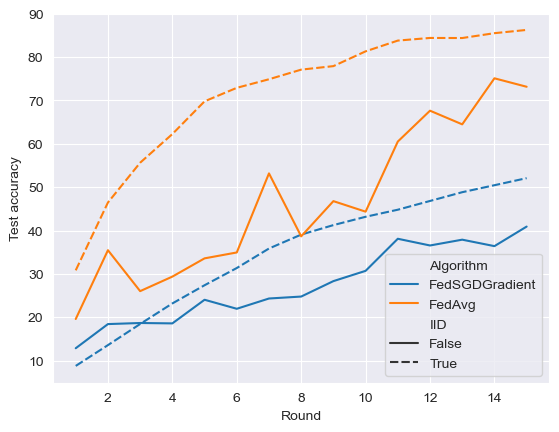

In [14]:
n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10
iids = [True, False]
dfs = []
for iid in iids:
    sample_split = split(n, iid, seed=10)
    server = FedSgdGradientServer(lr, sample_split, c, seed=seed)
    result = server.run(15)
    df_SDG = result.as_df()
    df_SDG["IID"] = iid
    server = FedAvgServer(lr, b, sample_split, c, e ,seed=seed)
    result = server.run(15)
    df_Avg = result.as_df()
    df_Avg["IID"] = iid
    dfs.append(df_SDG)
    dfs.append(df_Avg)

df = pd.concat(dfs)
sns.lineplot(data=df, x="Round", y="Test accuracy", hue="Algorithm", style="IID")

### How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?
Both algorithms achieve a better accuracy in the IID setting. The non-IID setting has a non-smooth learning curve, while the IID setting has a smoother learning curve.

<Axes: xlabel='Round', ylabel='Test accuracy'>

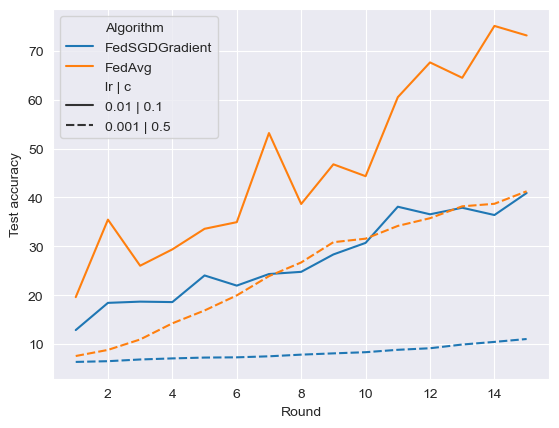

In [15]:
sample_split = split(n, False, seed=10)
server = FedSgdGradientServer(lr, sample_split, c, seed=seed)
result = server.run(15)
df_SDG = result.as_df()
df_SDG["lr | c"] = "0.01 | 0.1"
server = FedAvgServer(lr, b, sample_split, c, e ,seed=seed)
result = server.run(15)
df_Avg = result.as_df()
df_Avg["lr | c"] = "0.01 | 0.1"
dfs.append(df_SDG)
dfs.append(df_Avg)
server = FedSgdGradientServer(0.001, sample_split, 0.5, seed=seed)
result = server.run(15)
df_SDG = result.as_df()
df_SDG["lr | c"] = "0.001 | 0.5"
server = FedAvgServer(0.001, b, sample_split, 0.5, e ,seed=seed)
result = server.run(15)
df_Avg = result.as_df()
df_Avg["lr | c"] = "0.001 | 0.5"
dfs.append(df_SDG)
dfs.append(df_Avg)

df = pd.concat(dfs)
sns.lineplot(data=df, x="Round", y="Test accuracy", hue="Algorithm", style="lr | c")

### How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?
The stability of the new variants is higher than the old ones. The changes in parameters have the observed effect because the learning rate is lower and the client fraction is higher. A higher client fraction means that each average is done with more client data (less variance), which increases the stability of the training process. A lower learning rate means that the model is updated slowly, which loweres the chance of "jumping" over the optimal solution.

## Part B (12 points)

### Exercise B1: Microbatch Pipeline Model Parallelism (7 points)

Implement pipeline parallelism with microbatches, as discussed during the lab.

As with the other data/model parallelism examples, you will need a Python script for the nodes and a shell script to orchestrate execution.

Be aware of the possibility of deadlocks: due to how `good` operates, it is possible to deadlock by having device 1 send $B_2$ to device 2 in the forward pass, and simultaneously, device 2 send $B_1$ in the backward pass.
Since both operations will await a corresponding receive the training will stop indefinitely.

Use `isend` & `irecv`, the asynchronous (non-blocking) versions of `send` & `recv` in `torch.distributed`.
Add comments or text explaining how you expect your implementation to work and test that it runs for the same number of steps and model architecture as in class.

Note that `torch.distributed`'s implementation of `gloo` does not currently support properly asynchronous communication even when using the corresponding primitives.
Thus, you will not see the same improvements in speed as with a backend like `nccl`.

You may also take advantage of the fact that `torch` gradients naturally accumulate if zeroed out.
Also, scaling the loss by a constant is equivalent to scaling the resulting gradients by the same constant.

### Exercise B2: Joint Data & Model Parallelism (5 points)

Implement a training setup that uses data and model parallelism together.

Create 2 pipelines of 3 stages running sequentially, where each stage works with 3 sequential micro-batches.

Once again, add comments or text explaining your implementation and test it on the setting that mimics those from the class.

You can use groups from `torch.distributed` to handle operations that require interaction between a subset of more than two but less than all workers.